# Recommender Service Performance Metrics

The requirements for this exercise are to have at least
- 50 requests per second.

The latency requirement is to have:
- P75 < 200ms
- P99 < 700ms

This service includes three recommendation techniques:
- A base co-occurrence model
- A Tag2Vec model and
- An association rules model

These three models are combined using the RRF (reciprocal rank fusion) method to rerank the final results.

In [ ]:
# This notebook runs the performance metrics for the recommender service
# in sequential order. For a concurrent test, please refer to the
# README.md file and the CLI. 

In [1]:
import requests
import pandas as pd
from time import time
from tqdm import tqdm

In [2]:
# Function to get recommendations from the API given a list of tags
def get_recommendations(tags, num_tags):
    url = "http://0.0.0.0:8000/recommend"

    headers = {"accept": "application/json", "Content-Type": "application/json"}
    payload = {"tags": tags, "num_tags": num_tags}

    response = requests.post(url, json=payload, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get recommendations: {response.status_code}")
        return None

In [3]:
# Load test data from parquet file to test the API
df = pd.read_parquet("../data/processed/test.parquet", columns=["tags"])

In [4]:
# Test the API with different topn values and measure the time it takes to get the recommendations
results = list()

for topn in range(5, 31, 5):
    print(topn)

    for arr in tqdm(df["tags"].sample(2500)):
        tags = ",".join(arr)
        s = time()
        res = get_recommendations(tags, topn)
        e = time()
        # Convert time to milliseconds
        elapsed_time_ms = (e - s) * 1000
        results.append(
            {
                "tags": arr,
                "len_tags": len(arr),
                "res": res,
                "time_ms": elapsed_time_ms,
                "topn": topn,
            }
        )

all_results = pd.DataFrame(results)
all_results

# The tqdm shows the number of requests per second.
# Given that the expected traffic is 50 hz, the service seems
# to accommodate 9x to 10x.

5


100%|██████████| 2500/2500 [00:05<00:00, 448.36it/s]


10


100%|██████████| 2500/2500 [00:06<00:00, 388.89it/s]


15


100%|██████████| 2500/2500 [00:06<00:00, 382.14it/s]


20


100%|██████████| 2500/2500 [00:05<00:00, 443.52it/s]


25


100%|██████████| 2500/2500 [00:06<00:00, 409.95it/s]


30


100%|██████████| 2500/2500 [00:06<00:00, 398.37it/s]


,tags,len_tags,res,time_ms,topn
0,[aldbdldhlfhfl_i_thot_that_was_his_arm_in_the_...,1,{'input_tags': 'aldbdldhlfhfl_i_thot_that_was_...,12.484789,5
1,"[cashforcars, gowanbrae, cashforcars_gowanbrae]",3,"{'input_tags': 'cashforcars,gowanbrae,cashforc...",11.636972,5
2,[never_in_my_whole_time_working_here_has_a_cus...,3,{'input_tags': 'never_in_my_whole_time_working...,9.159327,5
3,[ateezy],1,"{'input_tags': 'ateezy', 'tags': [{'tag': 'z_x...",10.786057,5
4,"[wednesday, wenclair, fanart]",3,"{'input_tags': 'wednesday,wenclair,fanart', 't...",3.843069,5
...,...,...,...,...,...
14995,[probably_spreads_links_trough_d_ms_or_comment...,6,{'input_tags': 'probably_spreads_links_trough_...,2.841711,30
14996,"[love, lovers, romance, romantic, couple, goal...",11,"{'input_tags': 'love,lovers,romance,romantic,c...",2.564907,30
14997,"[豊永阿紀, hk_t48]",2,"{'input_tags': '豊永阿紀,hk_t48', 'tags': [{'tag':...",3.331661,30
14998,[instagram],1,"{'input_tags': 'instagram', 'tags': [{'tag': '...",3.175974,30


In [5]:
# Show statistics for number of tags, for time in milliseconds, and the topn
all_results.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

,len_tags,time_ms,topn
count,15000.000000,15000.000000,15000.00000
mean,3.144400,2.417200,17.50000
std,3.635294,1.069727,8.53941
min,0.000000,1.374245,5.00000
50%,2.000000,2.177000,17.50000
75%,4.000000,2.641916,25.00000
90%,7.000000,3.255224,30.00000
95%,10.000000,3.708386,30.00000
99%,20.000000,5.512965,30.00000
max,30.000000,46.345949,30.00000


In [6]:
all_results.groupby("topn")["time_ms"].describe(percentiles=[0.5, 0.75, 0.90, 0.99])

,count,mean,std,min,50%,75%,90%,99%,max
topn,,,,,,,,,
5,2500.0,2.210259,0.893158,1.374245,2.032876,2.338946,2.801538,4.835114,16.990900
10,2500.0,2.550426,1.264800,1.417875,2.279162,2.865553,3.542662,5.956326,33.458233
15,2500.0,2.593504,0.881118,1.461983,2.379417,2.960026,3.560257,5.431178,14.451981
20,2500.0,2.238188,0.702700,1.413107,2.079487,2.417326,2.971315,4.305832,21.422148
25,2500.0,2.420189,0.934425,1.428843,2.203107,2.635479,3.238058,5.425892,23.647070
30,2500.0,2.490636,1.482657,1.509905,2.189040,2.619088,3.222942,7.694008,46.345949


In [7]:
# Correlation between len_tags and time_ms
# No significant correlation whatsoever
correlation = all_results[["len_tags", "time_ms"]].corr()
correlation

,len_tags,time_ms
len_tags,1.000000,0.267734
time_ms,0.267734,1.000000


In [8]:
# Correlation between topn and time_ms
# Again, no correlation between the time in milliseconds and the number of requested results
correlation = all_results[["topn", "time_ms"]].corr()
correlation

,topn,time_ms
topn,1.000000,0.029918
time_ms,0.029918,1.000000


<Axes: ylabel='Frequency'>

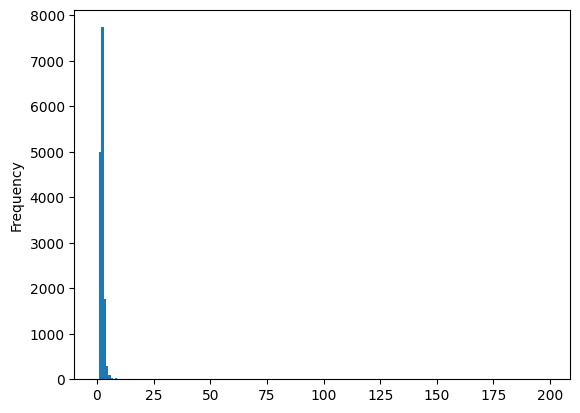

In [9]:
all_results.time_ms.plot(kind="hist", bins=range(200))

<Axes: ylabel='Frequency'>

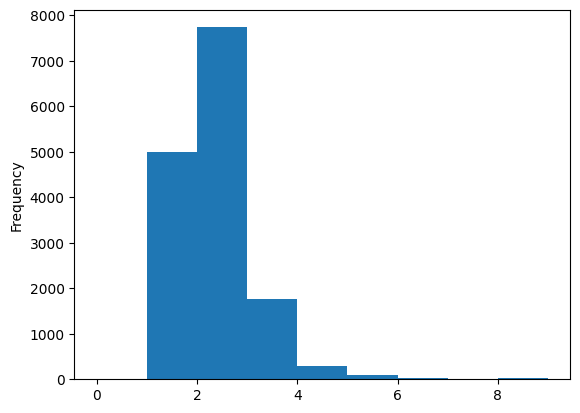

In [14]:
all_results.time_ms.plot(kind="hist", bins=range(10))

In [11]:
# Grouping by topn to calculate average time
average_time_by_topn = all_results.groupby("topn")["time_ms"].mean()
average_time_by_topn

topn
5     2.210259
10    2.550426
15    2.593504
20    2.238188
25    2.420189
30    2.490636
Name: time_ms, dtype: float64

<Axes: title={'center': 'Average time (ms) per topn'}, xlabel='topn'>

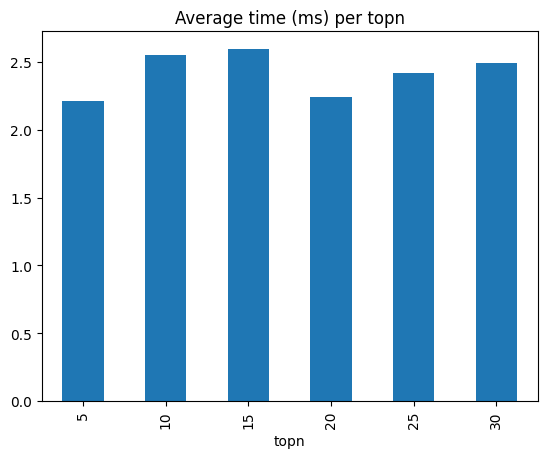

In [12]:
average_time_by_topn.plot(kind="bar", title="Average time (ms) per topn")

In [13]:
all_results["time_ms"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    15000.000000
mean         2.417200
std          1.069727
min          1.374245
50%          2.177000
75%          2.641916
90%          3.255224
95%          3.708386
99%          5.512965
max         46.345949
Name: time_ms, dtype: float64